# Cat vs Dog Classifier using CNN

### Downloading dataset

In [2]:
!mkdir -p /root/.kaggle
!cp kaggle.json /root/.kaggle

In [3]:
!kaggle datasets download -d salader/dogs-vs-cats

 99% 1.05G/1.06G [00:10<00:00, 201MB/s]
100% 1.06G/1.06G [00:10<00:00, 111MB/s]


In [4]:
import zipfile
zip_ref = zipfile.ZipFile('/content/dogs-vs-cats.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

## Building CNN Model

### Import libraries

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
from keras.applications.vgg16 import VGG16

### Creating Generators
##### Helpful for processing huge data Converts big data to batches

In [6]:
# train_df = keras.utils.image_dataset_from_directory(
#     directory = '/content/train',
#     labels = 'inferred',
#     label_mode = 'int',
#     batch_size = 32, 
#     image_size = (150, 150)
# )

In [7]:
# test_df = keras.utils.image_dataset_from_directory(
#     directory = '/content/test',
#     labels = 'inferred',
#     label_mode = 'int',
#     batch_size = 32, 
#     image_size = (150, 150)
# )

### Data Augmentation
#### Helpful for brining Invariance in Data

In [8]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

In [9]:
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
        # rotation_range=40,
        # width_shift_range=0.2,
        # height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        # fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [10]:
train_generator = train_datagen.flow_from_directory(
      '/content/train',
      target_size=(150, 150),
      batch_size=BATCH_SIZE,
      class_mode = 'binary'
     )

test_generator = train_datagen.flow_from_directory(
      '/content/test',
      target_size=(150, 150),
      batch_size=BATCH_SIZE,
      class_mode = 'binary'
     )

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


### Normalizing the train data and test data

In [11]:
# def normalize(image, label):
#   img = tf.cast(image/255. , tf.float32)
#   return img, label

# train_data = train_df.map(normalize)
# test_data = test_df.map(normalize)

### Make VGG16 model

In [12]:
conv_base = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3)
    )

58889256/58889256 [==============================] - 1s 0us/step


In [13]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [14]:
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [15]:
model.summary() # before freezing conv_base

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 16,845,121
Trainable params: 16,845,121
Non-trainable params: 0
_________________________________________________________________


In [16]:
conv_base.trainable = False

In [17]:
model.summary() # After freezing conv_base of VGG16

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 16,845,121
Trainable params: 2,130,433
Non-trainable params: 14,714,688
_________________________________________________________________


In [18]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [19]:
history = model.fit_generator(train_generator, epochs=10, validation_data=test_generator)

<ipython-input-19-c61f59e3ffb0>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, epochs=10, validation_data=test_generator)


Epoch 1/10
625/625 [==============================] - 215s 327ms/step - loss: 0.2985 - accuracy: 0.8668 - val_loss: 0.2377 - val_accuracy: 0.8956
Epoch 2/10
625/625 [==============================] - 203s 324ms/step - loss: 0.2419 - accuracy: 0.8945 - val_loss: 0.2403 - val_accuracy: 0.8954
Epoch 3/10
625/625 [==============================] - 208s 332ms/step - loss: 0.2207 - accuracy: 0.9045 - val_loss: 0.2267 - val_accuracy: 0.9048
Epoch 4/10
625/625 [==============================] - 207s 331ms/step - loss: 0.2113 - accuracy: 0.9101 - val_loss: 0.2242 - val_accuracy: 0.9070
Epoch 5/10
625/625 [==============================] - 204s 327ms/step - loss: 0.1956 - accuracy: 0.9158 - val_loss: 0.2119 - val_accuracy: 0.9150
Epoch 6/10
625/625 [==============================] - 203s 324ms/step - loss: 0.1878 - accuracy: 0.9204 - val_loss: 0.2113 - val_accuracy: 0.9088
Epoch 7/10
625/625 [==============================] - 202s 323ms/step - loss: 0.1775 - accuracy: 0.9241 - val_loss: 0.2262 -

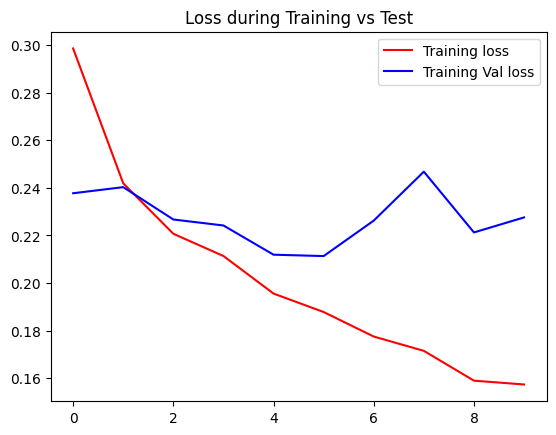

In [20]:
plt.title('Loss during Training vs Test')
plt.plot(history.history['loss'], color='red', label = 'Training loss')
plt.plot(history.history['val_loss'], color='blue', label = 'Training Val loss')
plt.legend()
plt.show()

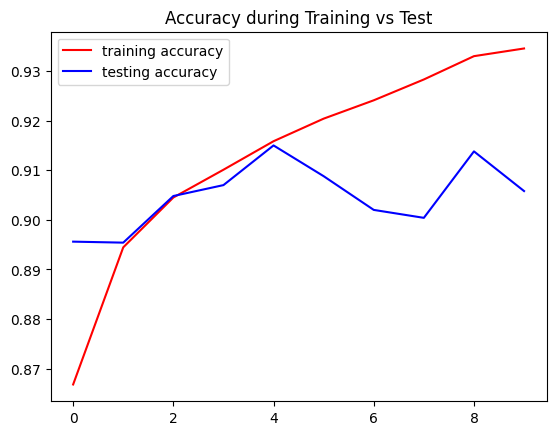

In [21]:
plt.title('Accuracy during Training vs Test')
plt.plot(history.history['accuracy'], color='red', label='training accuracy')
plt.plot(history.history['val_accuracy'], color='blue', label='testing accuracy')
plt.legend()
plt.show()

## Predicting Outcomes

In [23]:
import cv2
def predict(image_path):
  img = cv2.imread(image_path)
  plt.imshow(img)
  img = cv2.resize(img, (150, 150))
  img_input = img.reshape((1, 150, 150, 3))
  predictions = model.predict(img_input)
  return 'dog' if predictions == 1. else 'cat'

In [24]:
test_image_paths = ['/content/cat.0.jpg', '/content/cat.25.jpg', '/content/cat.27.jpg', '/content/dog.30.jpg', '/content/dog.367.jpg', '/content/dog.45.jpg']

1/1 [==============================] - 1s 810ms/step


'cat'

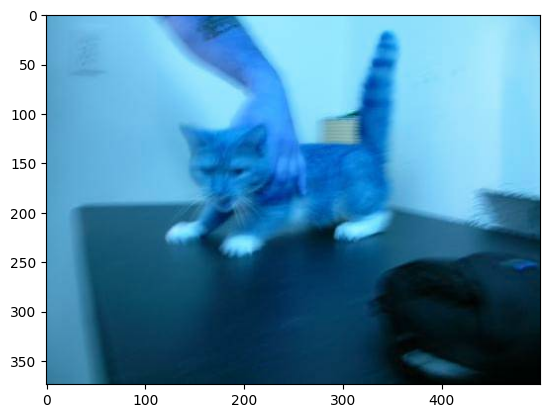

In [25]:
predict(test_image_paths[0])

1/1 [==============================] - 0s 19ms/step


'dog'

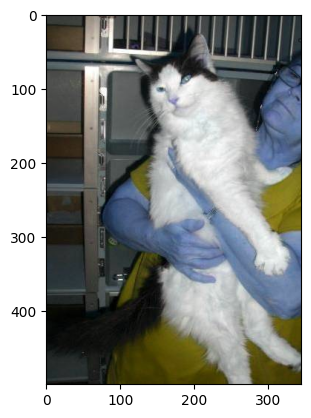

In [26]:
predict(test_image_paths[1])

1/1 [==============================] - 0s 23ms/step


'cat'

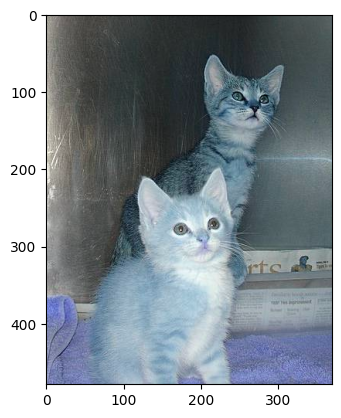

In [27]:
predict(test_image_paths[2])

1/1 [==============================] - 0s 21ms/step


'dog'

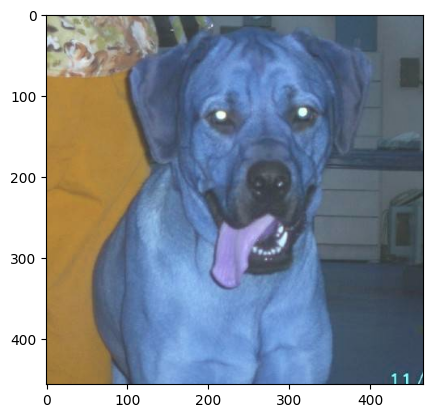

In [28]:
predict(test_image_paths[3])

1/1 [==============================] - 0s 19ms/step


'dog'

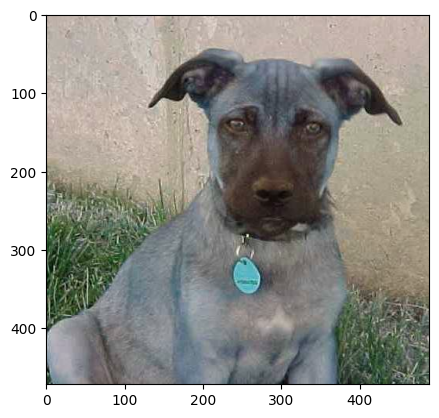

In [29]:
predict(test_image_paths[4])

1/1 [==============================] - 0s 22ms/step


'dog'

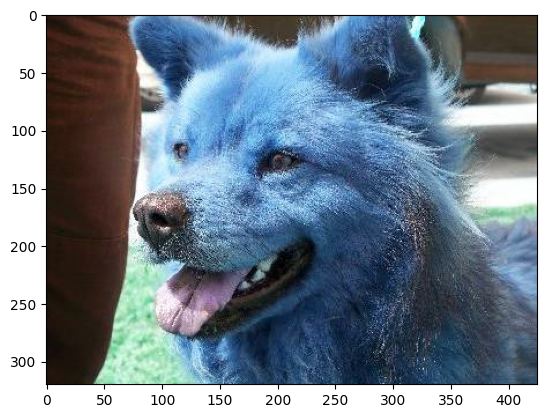

In [30]:
predict(test_image_paths[5])

## Saving Model

In [31]:
model.save('cat-dog_vgg16_cnn.h5')